In [1]:
# Import necessary libraries
import os
import networkx as nx
import openai 
import matplotlib.pyplot as plt
import sys
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import hydra
import numpy as np
import pandas as pd
import pickle
import torch

sys.path.append('../../..')
from aiagents4pharma.talk2knowledgegraphs.utils.extractions.multimodal_pcst import MultimodalPCSTPruning
from aiagents4pharma.talk2knowledgegraphs.utils.embeddings.ollama import EmbeddingWithOllama
from aiagents4pharma.talk2knowledgegraphs.utils.embeddings.sentence_transformer import EmbeddingWithSentenceTransformer

# from aiagents4pharma.talk2knowledgegraphs.tools.subgraph_extraction import SubgraphExtractionTool
# from aiagents4pharma.talk2knowledgegraphs.tools.subgraph_summarization import SubgraphSummarizationTool
# from aiagents4pharma.talk2knowledgegraphs.tools.graphrag_reasoning import GraphRAGReasoningTool

/home/awmulyadi/Repositories/temp/office2/AIAgents4Pharma/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:aiagents4pharma.talk2scholars.tools.pdf.question_and_answer:Loaded Question and Answer tool configuration.
/home/awmulyadi/Repositories/temp/office2/AIAgents4Pharma/venv/lib/python3.12/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/awmulyadi/Repositories/temp/office2/AIAgents4Pharma/venv/lib/python3.12/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/awmulyadi/Repositories/temp/office2/AIAgents4Pharma/venv/lib/python3.12/site-packages/torch_geometric/typing.py:12

In [ ]:
os.environ["OPENAI_API_KEY"] = "XXX"
# Make sure to replace "your_api_key" with your actual API key.

In [3]:
# Load hydra configuration
with hydra.initialize(version_base=None, config_path="../../../aiagents4pharma/talk2knowledgegraphs/configs"):
    cfg = hydra.compose(
        config_name="config", overrides=["tools/subgraph_extraction=default"]
    )
    cfg = cfg.tools.subgraph_extraction
cfg

{'_target_': 'talk2knowledgegraphs.tools.subgraph_extraction', 'ollama_embeddings': ['nomic-embed-text'], 'temperature': 0.1, 'streaming': False, 'topk': 5, 'topk_e': 5, 'cost_e': 0.5, 'c_const': 0.01, 'root': -1, 'num_clusters': 1, 'pruning': 'gw', 'verbosity_level': 0, 'node_id_column': 'node_id', 'node_attr_column': 'node_attr', 'edge_src_column': 'edge_src', 'edge_attr_column': 'edge_attr', 'edge_dst_column': 'edge_dst', 'prompt_endotype_filtering': 'You are talk2knowledgegraphs agent, a helpful assistant in filtering the most relevant endotype for the subgraph extraction process. Given the retrieved endotype documents, you need to filter the most relevant endotype that will be used for the following reasoning process. Only included a list of genes that exist in the provided documents that are relevant to the input query. For this task, you may modify your prompt to optimize the filtering process based on factual informationbetween each gene in the documents and the input query. Di

In [12]:
# Define state
state = {
    "llm_model": ChatOpenAI(model="gpt-4o-mini", temperature=0.0),
    "embedding_model": OpenAIEmbeddings(model="text-embedding-3-small"),
    "selected_genes": ["IL6_(1567)", "IL21_(34967)", "TNF_(2329)"],
    "selected_drugs": ["Remdesivir_(15267)", "Mesalazine_(15876)"],
    "uploaded_files": [],
    "topk_nodes": 10,
    "topk_edges": 10,
    "dic_source_graph": [
        {
            "name": "PrimeKG",
            "kg_pyg_path": "../../../aiagents4pharma/talk2knowledgegraphs/tests/files/biobridge_multimodal_pyg_graph.pkl",
            "kg_text_path": "../../../aiagents4pharma/talk2knowledgegraphs/tests/files/biobridge_multimodal_text_graph.pkl",
        }
    ],
    "dic_extracted_graph": []
}

# Define prompt
prompt = """
Extract all relevant information related to nodes of genes related to inflammatory bowel disease (IBD) 
that existed in the knowledge graph.

Please set the extraction name for this process as `subkg_12345`.
"""

In [5]:
# Retrieve source graph from the state
initial_graph = {}
initial_graph["source"] = state["dic_source_graph"][-1]  # The last source graph as of now
# logger.log(logging.INFO, "Source graph: %s", source_graph)

# Load the knowledge graph
with open(initial_graph["source"]["kg_pyg_path"], "rb") as f:
    initial_graph["pyg"] = pickle.load(f)
with open(initial_graph["source"]["kg_text_path"], "rb") as f:
    initial_graph["text"] = pickle.load(f)


In [6]:
# Define feature columns 
dict_feature = {
    "gene/protein": "sequence",
    "molecular_function": "text",
    "cellular_component": "text",
    "biological_process": "text",
    "drug": "smiles",
    "disease": "text",
}

In [7]:
graph = initial_graph["pyg"]

# Convert PyG graph to a DataFrame
graph_df = pd.DataFrame({
    "node_id": graph.node_id,
    "node_type": graph.node_type,
    "feature": [dict_feature[graph.node_type[i]] for i in range(len(graph.node_type))],
    "x": [list(x) for x in graph.x],
    "score": [0.0 for _ in range(len(graph.node_id))],
})
graph_df

,node_id,node_type,feature,x,score
0,SMAD3_(144),gene/protein,sequence,"[-0.014456028118729591, -0.03834506496787071, ...",0.0
1,IL10RB_(179),gene/protein,sequence,"[-0.06711604446172714, 0.058091215789318085, 0...",0.0
2,GNA12_(192),gene/protein,sequence,"[-0.015191752463579178, -0.13006462156772614, ...",0.0
3,HNF4A_(279),gene/protein,sequence,"[0.0008836743654683232, 0.011145174503326416, ...",0.0
4,VCAM1_(417),gene/protein,sequence,"[0.008272849954664707, 0.04085301235318184, 0....",0.0
...,...,...,...,...,...
2986,synaptic vesicle membrane_(127256),cellular_component,text,"[0.060017575, 0.06460427, -0.133244, -0.037536...",0.0
2987,site of double-strand break_(127358),cellular_component,text,"[0.06581898, -0.00717352, -0.17252395, -0.0765...",0.0
2988,amphisome_(127370),cellular_component,text,"[0.019827422, 0.040153842, -0.14598823, -0.068...",0.0
2989,caveola_(127374),cellular_component,text,"[0.06788855, 0.09054889, -0.14516972, -0.06371...",0.0


In [8]:
def minmax(x):
    return (x - x.min()) / (x.max() - x.min())

In [13]:
state["selected_genes"]

['IL6_(1567)', 'IL21_(34967)', 'TNF_(2329)']

In [10]:
state["selected_drugs"]

['Remdesivir_(15267)', 'Mesalazine_(15876)']

In [15]:
# Prepare embeddings and modalities
query_embs = []
modalities = []

# Text-based embeddings
query_embs.append(
    torch.tensor(
        EmbeddingWithOllama(model_name=cfg.ollama_embeddings[0]).embed_query(prompt)
        # EmbeddingWithSentenceTransformer(
        #     model_name='nomic-ai/nomic-embed-text-v1.5',
        #     model_cache_dir="../../../../data/nomic-ai/nomic-embed-text-v1.5/",
        #     trust_remote_code=True).embed_query("search_query:" + prompt)
    ).float()
)
modalities.append("text")

# Obtain another features from the selected genes
for gene in state["selected_genes"]:
    query_embs.append(torch.tensor(
        initial_graph["pyg"].x[
            np.where(np.array(initial_graph["pyg"].node_id) == gene)[0][0]
        ]
    ))
    modalities.append("sequence")

# Obtain another features from the selected drugs
for drug in state["selected_drugs"]:
    query_embs.append(torch.tensor(
        initial_graph["pyg"].x[
            np.where(np.array(initial_graph["pyg"].node_id) == drug)[0][0]
        ]
    ))
    modalities.append("smiles")

INFO:httpx:HTTP Request: GET http://127.0.0.1:11434/api/tags "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


In [23]:
modalities

['text', 'sequence', 'sequence', 'sequence', 'smiles', 'smiles']

In [24]:
len(query_embs[5])

512

In [25]:
# # Try for the first query embedding and modality
# query_emb = query_embs[0]
# modality = modalities[0]

# Initialize the subgraph dictionary
subgraphs = {}
subgraphs["nodes"] = []
subgraphs["edges"] = []

# Loop over modalities and query embeddings
for modality, query_emb in zip(modalities, query_embs):
    print(f"Processing modality: {modality}")
    # print(f"Query embedding: {query_emb}")
    # Prepare the PCSTPruning object and extract the subgraph
    # Parameters were set in the configuration file obtained from Hydra
    subgraph = MultimodalPCSTPruning(                                         
        state["topk_nodes"],
        state["topk_edges"],
        cfg.cost_e,
        cfg.c_const,
        cfg.root,
        cfg.num_clusters,
        cfg.pruning,
        cfg.verbosity_level,
    ).extract_subgraph(initial_graph["pyg"],
                       query_embs[0], # treat the first query embedding as the prompt embedding
                       query_emb, 
                       modality)

    subgraphs["nodes"].append(subgraph["nodes"].tolist())
    subgraphs["edges"].append(subgraph["edges"].tolist())

subgraphs["nodes"] = np.unique(np.concatenate([np.array(list_) for list_ in subgraphs["nodes"]]))
subgraphs["edges"] = np.unique(np.concatenate([np.array(list_) for list_ in subgraphs["edges"]]))

Processing modality: text
Processing modality: sequence
Processing modality: sequence
Processing modality: sequence
Processing modality: smiles
Processing modality: smiles


In [33]:
subgraph = subgraphs

In [34]:
def dict_to_nx_graph(graph_dict):
    """
    Convert a dictionary representation of a graph to a NetworkX graph.
    """
    # Create a directed graph
    graph = nx.DiGraph()

    # Add nodes with attributes
    for node, attrs in graph_dict["nodes"]:
        graph.add_node(node, **attrs)

    # Add edges with attributes
    for source, target, attrs in graph_dict["edges"]:
        graph.add_edge(source, target, **attrs)

    return graph

In [35]:
pyg_graph = initial_graph["pyg"]
from torch_geometric.data import Data

# print(subgraph)
# Prepare the PyTorch Geometric graph
mapping = {n: i for i, n in enumerate(subgraph["nodes"].tolist())}
pyg_graph = Data(
    # Node features
    x=[pyg_graph.x[i] for i in subgraph["nodes"]],
    node_id=np.array(pyg_graph.node_id)[subgraph["nodes"]].tolist(),
    node_name=np.array(pyg_graph.node_id)[subgraph["nodes"]].tolist(),
    enriched_node=np.array(pyg_graph.enriched_node)[subgraph["nodes"]].tolist(),
    num_nodes=len(subgraph["nodes"]),
    # Edge features
    edge_index=torch.LongTensor(
        [
            [
                mapping[i]
                for i in pyg_graph.edge_index[:, subgraph["edges"]][0].tolist()
            ],
            [
                mapping[i]
                for i in pyg_graph.edge_index[:, subgraph["edges"]][1].tolist()
            ],
        ]
    ),
    edge_attr=pyg_graph.edge_attr[subgraph["edges"]],
    edge_type=np.array(pyg_graph.edge_type)[subgraph["edges"]].tolist(),
    relation=np.array(pyg_graph.edge_type)[subgraph["edges"]].tolist(),
    label=np.array(pyg_graph.edge_type)[subgraph["edges"]].tolist(),
    enriched_edge=np.array(pyg_graph.enriched_edge)[subgraph["edges"]].tolist(),
)

In [44]:
# Networkx DiGraph construction to be visualized in the frontend
nx_graph = nx.DiGraph()
for n in pyg_graph.node_name:
    if n in state["selected_genes"]:
        nx_graph.add_node(n, metadata={"color":"red"})
    elif n in state["selected_drugs"]:
        nx_graph.add_node(n, metadata={"color":"green"})
    else:
        nx_graph.add_node(n)
for i, e in enumerate(
    [
        [pyg_graph.node_name[i], pyg_graph.node_name[j]]
        for (i, j) in pyg_graph.edge_index.transpose(1, 0)
    ]
):
    nx_graph.add_edge(
        e[0],
        e[1],
        relation=pyg_graph.edge_type[i],
        label=pyg_graph.edge_type[i],
    )

In [45]:
nx_graph.nodes(data=True)

NodeDataView({'IL7R_(625)': {}, 'PPARG_(989)': {}, 'IL6_(1567)': {'metadata': {'color': 'red'}}, 'JAK2_(1618)': {}, 'IL1R2_(1654)': {}, 'LRRK2_(2111)': {}, 'TNF_(2329)': {'metadata': {'color': 'red'}}, 'CASP3_(2712)': {}, 'PRDM1_(2874)': {}, 'TGFB1_(2889)': {}, 'IL10_(2983)': {}, 'LTF_(3233)': {}, 'CARD9_(3460)': {}, 'SLC22A5_(3484)': {}, 'IFNG_(3495)': {}, 'ECM1_(3578)': {}, 'ABCB1_(4152)': {}, 'MPO_(4818)': {}, 'MST1_(4997)': {}, 'ITGAM_(5022)': {}, 'TCF7_(5195)': {}, 'IL12B_(6168)': {}, 'NOD2_(6229)': {}, 'ICOSLG_(9454)': {}, 'TLR9_(10113)': {}, 'LEP_(11523)': {}, 'IL18RAP_(11588)': {}, 'CCR6_(12740)': {}, 'Atazanavir_(14296)': {}, 'Atorvastatin_(14297)': {}, 'Saquinavir_(14319)': {}, 'Favipiravir_(14466)': {}, 'Elexacaftor_(14499)': {}, 'Niacin_(14506)': {}, 'Dopamine_(14641)': {}, 'Aminosalicylic acid_(14772)': {}, 'Remdesivir_(15267)': {'metadata': {'color': 'green'}}, 'Dihydroergotamine_(15431)': {}, 'Bromocriptine_(15493)': {}, 'Vorapaxar_(15610)': {}, 'Tazemetostat_(15698)': {

In [37]:
nx_graph

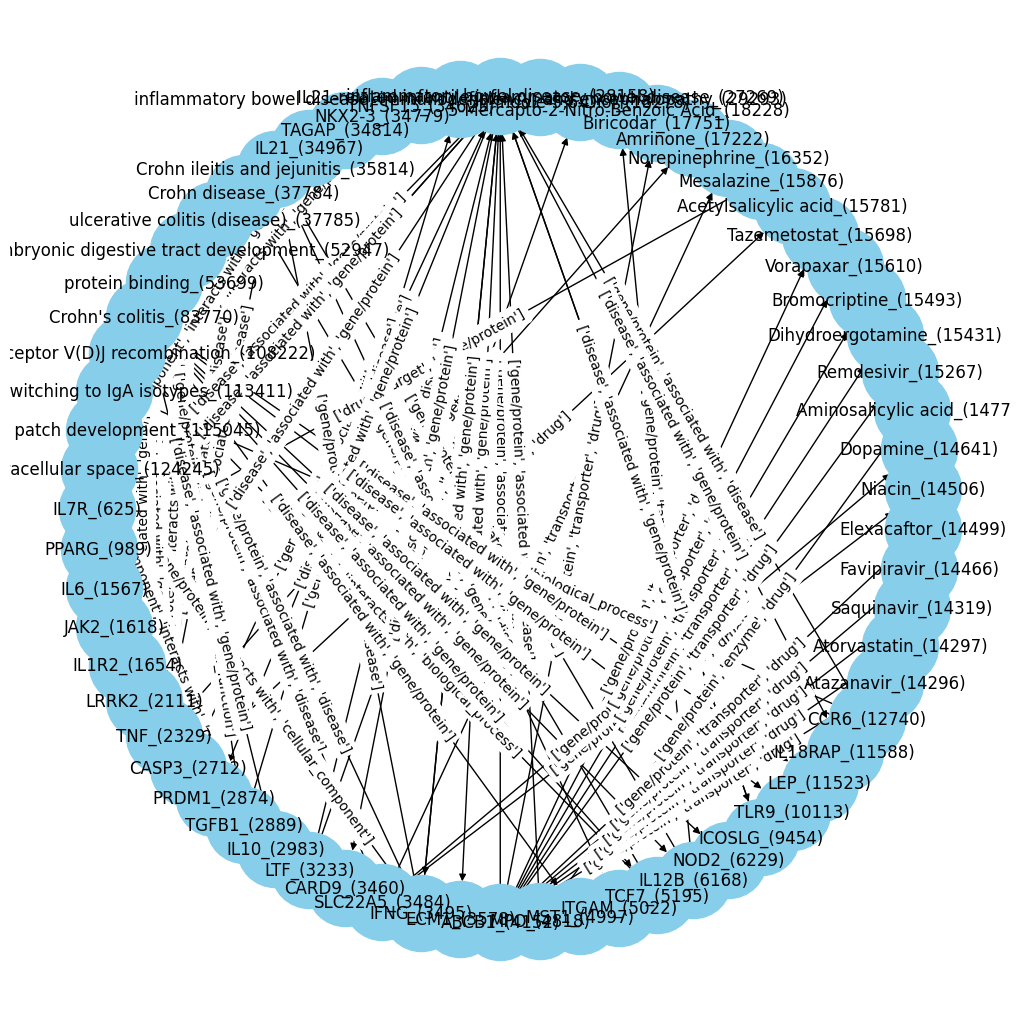

In [41]:
# Extracted subgraph 
# nx_graph = dict_to_nx_graph(['graph_dict'])

# Visualize the extracted subgraph
# Make a simple plot of the knowledge graph
plt.figure(figsize=(10, 10))
pos = nx.shell_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color='skyblue')
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels={(u, v): d['relation'] for u, v, d in nx_graph.edges(data=True)})
plt.show()

In [38]:
subgraph["nodes"]

array([   5,    9,   14,   15,   16,   22,   24,   28,   30,   31,   33,
         36,   40,   43,   44,   45,   47,   50,   52,   53,   54,   59,
         61,   73,   75,   81,   82,   85,  215,  216,  230,  289,  307,
        308,  338,  371,  526,  554,  570,  596,  616,  633,  647,  691,
        733,  756,  762,  764,  839,  840,  841,  842,  846,  849,  851,
        853,  854,  855, 1820, 1863, 2113, 2447, 2682, 2733, 2886])

In [40]:
subgraph["edges"]

array([  553,   557,  1657,  1659,  1700,  1830,  1934,  2009,  2097,
        2099,  2459,  2521,  2847,  2884,  2894,  2903,  2930,  2931,
        2932,  2936,  3077,  3176,  3329,  3330,  3360,  3371,  3416,
        3477,  3555,  3564,  3599,  3609,  3738,  3776,  3930,  3954,
        4194,  4271,  4703,  5215,  5246,  5983,  6303,  6305,  6314,
        6321,  6345,  6349,  6357,  6360,  6363,  6372,  6381,  6405,
        6490,  6667,  6712,  6776,  9668,  9669,  9670,  9671,  9672,
        9674,  9685,  9687,  9693,  9696,  9699,  9700, 10809, 11070,
       11078])

In [39]:
textualized_graph = initial_graph["text"]

# Prepare the textualized subgraph
textualized_graph = (
    textualized_graph["nodes"].iloc[subgraph["nodes"]].to_csv(index=False)
    + "\n"
    + textualized_graph["edges"].iloc[subgraph["edges"]].to_csv(index=False)
)

print(textualized_graph)

node_id,node_attr
IL7R_(625),"IL7R belongs to gene/protein node. IL7R is interleukin 7 receptor. The protein encoded by this gene is a receptor for interleukin 7 (IL7). The function of this receptor requires the interleukin 2 receptor, gamma chain (IL2RG), which is a common gamma chain shared by the receptors of various cytokines, including interleukins 2, 4, 7, 9, and 15. This protein has been shown to play a critical role in V(D)J recombination during lymphocyte development. Defects in this gene may be associated with severe combined immunodeficiency (SCID). Alternatively spliced transcript variants have been found. [provided by RefSeq, Dec 2015]."
PPARG_(989),"PPARG belongs to gene/protein node. PPARG is peroxisome proliferator activated receptor gamma. This gene encodes a member of the peroxisome proliferator-activated receptor (PPAR) subfamily of nuclear receptors. PPARs form heterodimers with retinoid X receptors (RXRs) and these heterodimers regulate transcription of various gen

In [85]:
textualized_graph = initial_graph["text"]

In [88]:
textualized_graph["nodes"].iloc[subgraph["nodes"]]

,node_id,node_attr
44,ADRB2_(1494),MGQPGNGSAFLLAPNGSHAPDHDVTQERDEVWVVGMGIVMSLIVLA...
47,immunoglobulin transcytosis in epithelial cell...,The process of transporting polymeric IgA and ...
66,Itraconazole_(14992),CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC...
140,BCL2_(2429),MAHAGRTGYDNREIVMKYIHYKLSQRGYEWDAGDVGAAPPGAAPAP...
255,"colorectal cancer, hereditary nonpolyposis,_(3...",A rare genetic neoplastic syndrome with an aut...
...,...,...
8275,immunodeficiency without anhidrotic ectodermal...,immunodeficiency without anhidrotic ectodermal...
8346,TCEANC_(6063),MSDKNQIAARASLIEQLMSKRNFEDLGNHLTELETIYVTKEHLQET...
8400,HDDC2_(12757),MASVSSATFSGHGARSLLQFLRLVGQLKRVPRTGWVYRNVQRPESV...
8425,ZFAND5_(8007),MAQETNQTPGPMLCSTGCGFYGNPRTNGMCSVCYKEHLQRQQNSGR...


{'nodes':                                                 node_id  \
0                                        ALG1L2_(59818)   
1                                            ERG_(3044)   
2             dihydropterin deaminase activity_(117428)   
3     molybdenum ion transmembrane transporter activ...   
4              epothilone biosynthetic process_(103188)   
...                                                 ...   
8494       negative regulation of ERK5 cascade_(108349)   
8495                               Perflubutane_(21523)   
8496              erythrophore differentiation_(111136)   
8497                          transsulfuration_(110314)   
8498  galactarate O-hydroxycinnamoyltransferase acti...   

                                              node_attr  
0     MGATAGWAVTVYDKPASFFKEAPLDLQHRLFMKLGSTHSPFRARSE...  
1     MASTIKEALSVVSEDQSLFECAYGTPHLAKTEMTASSSSDYGQTSK...  
2     Catalysis of the reaction: 7,8-dihydropterin +...  
3     Enables the transfer of molybdenum (Mo) ion

In [42]:
subgraph

{'nodes': array([1279, 2109, 2227, 2618, 4461, 4490, 5757, 6032, 6264, 6394, 8275,
        8400]),
 'edges': array([20379,  9904,  6344, 12554, 12556, 12558, 12563, 12570, 12574,
        12575, 12582])}

In [43]:
subgraphs

{'nodes': array([1279, 2109, 2227, 2618, 4461, 4490, 5757, 6032, 6264, 6394, 8275,
        8400]),
 'edges': array([ 6344,  9904, 12554, 12556, 12558, 12563, 12570, 12574, 12575,
        12582, 20379])}

In [26]:
subgraphs["nodes"]

array([1279, 2109, 2227, 2618, 4461, 4490, 5757, 6032, 6264, 6394, 8275,
       8400,  256,  330,  341, 2109, 2227, 2618, 2653, 2778, 2790, 3411,
       3714, 3817, 4490, 5023, 5150, 5207, 5654, 5757, 6264, 6394, 6477,
       6875, 6890, 7328, 7445, 7628, 8275, 8322, 8400, 1104, 2109, 2227,
       2618, 2653, 2903, 3035, 3305, 3364, 3649, 4063, 4418, 4490, 4501,
       4923, 5024, 5038, 5303, 5757, 6264, 6394, 6677, 7059, 7441, 7628,
       7755, 7978, 8275, 8400])

ValueError: zero-dimensional arrays cannot be concatenated

In [20]:
subgraphs["nodes"] = np.array(subgraphs["nodes"])
subgraphs["nodes"]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
np.empty((1,))

### Text-based Vector Similarities

In [ ]:
# Prepare features and node IDs for textual-based node features
graph_x_text = torch.tensor(list(graph_df[graph_df["feature"]== "text"].x.values))
graph_x_text_ids = graph_df[graph_df["feature"]== "text"].index.tolist()

# Calculate cosine similarity for text features and update the score
graph_df.loc[graph_df["feature"] == "text", "score"] = minmax(torch.nn.CosineSimilarity(dim=-1)(query_emb, graph_x_text)).tolist()

In [ ]:
graph_df

In [ ]:
torch.nn.CosineSimilarity(dim=-1)(query_emb, graph_x_text)

In [ ]:
torch.tensor(graph_df.score.values, dtype=torch.float32)

### Sequence-based Vector Similarities

In [ ]:
state["selected_genes"]

In [ ]:
graph

In [ ]:
graph.x[np.where(np.array(graph.node_id) == 'IL6R_(9234)')[0][0]]

In [ ]:
np.array(graph.node_id)[np.array(graph.node_id) == 'IL6R_(9234)']

In [ ]:
graph_df[graph_df["node_id"].isin(state["selected_genes"]) & (graph_df["feature"] == "sequence")]

In [ ]:
# Prepare features and node IDs for sequence-based node features
graph_x_seq = torch.tensor(list(graph_df[graph_df["feature"]== "sequence"].x.values))
graph_x_seq_ids = graph_df[graph_df["feature"]== "sequence"].index.tolist()

# Based on the selected genes, obtain the sequence embeddings 
# Treat the selected genes as query 
selected_genes_df = graph_df[graph_df["node_id"].isin(state["selected_genes"]) & (graph_df["feature"] == "sequence")]

# Loop through the selected genes and update the score
scores = []
for query_gene_x in torch.tensor(list(selected_genes_df["x"].values)):
    # Calculate cosine similarity for sequence features and update the score
    scores.append(torch.nn.CosineSimilarity(dim=-1)(query_gene_x, graph_x_seq).tolist())

    # Update the score in the DataFrame
    


# graph_df.loc[graph_df["feature"] == "sequence", "score"] = 

# for gene in selected_genes_df.iterrows():
#     query_ = gene
#     graph_df.loc[graph_df["node_id"] == "sequence", "score"] = torch.nn.CosineSimilarity(dim=-1)(query_emb, graph_x_seq).tolist()

In [ ]:
torch.tensor(graph.x[np.where(np.array(graph.node_id) == 'IL6R_(9234)')[0][0]])

In [ ]:
torch.tensor(scores)

In [ ]:

# Compute prizes for nodes
n_prizes = torch.nn.CosineSimilarity(dim=-1)(query_emb, graph.x)
topk = min(self_topk, graph.num_nodes)
_, topk_n_indices = torch.topk(n_prizes, topk, largest=True)
n_prizes = torch.zeros_like(n_prizes)
n_prizes[topk_n_indices] = torch.arange(topk, 0, -1).float()